In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Rectangle
from tools import *

%matplotlib inline

In [2]:
raw_results = list()
for filename in ['results/2019-10-01T16:46:19.017259-04:00.json',
                 'results/2019-10-02T16:07:35.437936-04:00.json']:
    with open(filename, 'r') as infile:
        raw_results += json.load(infile)
results = list_of_dicts_to_dict_of_lists(raw_results)
for key, value in results.items():
    results[key] = to_nested_tuples(value)
results = pd.DataFrame(data=results)
masks = pd.read_csv('mnist_masks.csv')

In [3]:
rdf = results.copy(deep=True)
rdf = rdf[rdf['success']]
for i in rdf.index:
    if (rdf.at[i, 'optimizer'] == 'sgd') and (str(rdf.at[i, 'momentum']) != '0.0'):
        rdf.at[i, 'optimizer'] = 'momentum'

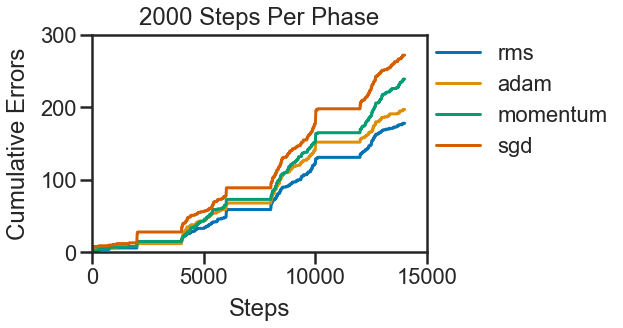

In [4]:
plt.clf()
summary = cumulative_errors_summary(rdf[rdf['criteria'] == 'steps'])
best = get_best(summary, 'errors')
sns.set_style('ticks')
sns.set_context('poster')
sns.set_palette('colorblind')
for optimizer, (settings, stats) in best.items():
    plt.plot(
        np.arange(len(stats['c_errors_avg'])),
        stats['c_errors_avg'],
        label=optimizer)
    plt.fill_between(
        np.arange(len(stats['c_errors_avg'])),
        stats['c_errors_avg'] - stats['c_errors_sem'],
        stats['c_errors_avg'] + stats['c_errors_sem'],
        alpha=0.3)
plt.legend(frameon=False, loc=(1, 0.4))
plt.xlabel('Steps', labelpad=10)
plt.xlim(0, 15000)
plt.ylabel('Cumulative Errors', labelpad=10)
plt.ylim(0, 300)
plt.title('2000 Steps Per Phase', pad=10)
plt.savefig('steps.pdf', bbox_inches='tight')

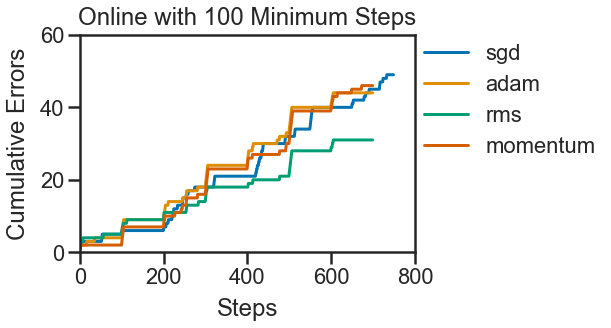

In [5]:
plt.clf()
summary = cumulative_errors_summary(rdf[(rdf['criteria'] == 'online') &
                                        (rdf['minimum_steps'] == 100)])
best = get_best(summary, 'errors')
sns.set_style('ticks')
sns.set_context('poster')
sns.set_palette('colorblind')
for optimizer, (settings, stats) in best.items():
    plt.plot(
        np.arange(len(stats['c_errors_avg'])),
        stats['c_errors_avg'],
        label=optimizer)
    plt.fill_between(
        np.arange(len(stats['c_errors_avg'])),
        stats['c_errors_avg'] - stats['c_errors_sem'],
        stats['c_errors_avg'] + stats['c_errors_sem'],
        alpha=0.3)
plt.legend(frameon=False, loc=(1, 0.4))
plt.xlabel('Steps', labelpad=10)
plt.xlim(0, 800)
plt.ylabel('Cumulative Errors', labelpad=10)
plt.ylim(0, 60)
plt.title('Online with 100 Minimum Steps', pad=10)
plt.savefig('online_100.pdf', bbox_inches='tight')

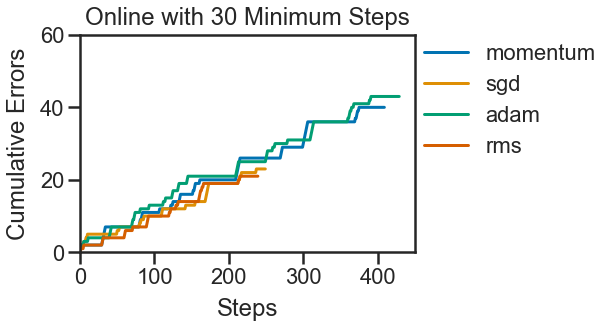

In [6]:
plt.clf()
summary = cumulative_errors_summary(rdf[(rdf['criteria'] == 'online') &
                                        (rdf['minimum_steps'] == 30)])
best = get_best(summary, 'errors')
sns.set_style('ticks')
sns.set_context('poster')
sns.set_palette('colorblind')
for optimizer, (settings, stats) in best.items():
    plt.plot(
        np.arange(len(stats['c_errors_avg'])),
        stats['c_errors_avg'],
        label=optimizer)
    plt.fill_between(
        np.arange(len(stats['c_errors_avg'])),
        stats['c_errors_avg'] - stats['c_errors_sem'],
        stats['c_errors_avg'] + stats['c_errors_sem'],
        alpha=0.3)
plt.legend(frameon=False, loc=(1, 0.4))
plt.xlabel('Steps', labelpad=10)
plt.xlim(0, 450)
plt.ylabel('Cumulative Errors', labelpad=10)
plt.ylim(0, 60)
plt.title('Online with 30 Minimum Steps', pad=10)
plt.savefig('online_30.pdf', bbox_inches='tight')

In [ ]:
print("Overall Success Rate")
a = len(results[(results['optimizer'] == 'sgd') & (results['momentum'] == '0.0') & (results['tolerance'] == 2500) & results['success']])
b = len(results[(results['optimizer'] == 'sgd') & (results['momentum'] == '0.0') & (results['tolerance'] == 2500)])
print("SGD: {0} / {1} ({2:.2f}%)".format(a, b, 100 * a / b))
a = len(results[(results['optimizer'] == 'sgd') & (results['momentum'] != '0.0') & (results['tolerance'] == 2500) & results['success']])
b = len(results[(results['optimizer'] == 'sgd') & (results['momentum'] != '0.0') & (results['tolerance'] == 2500)])
print("SGD with Momentum: {0} / {1} ({2:.2f}%)".format(a, b, 100 * a / b))
a = len(results[(results['optimizer'] == 'rms') & (results['tolerance'] == 2500) & results['success']])
b = len(results[(results['optimizer'] == 'rms') & (results['tolerance'] == 2500)])
print("RMSProp: {0} / {1} ({2:.2f}%)".format(a, b, 100 * a / b))
a = len(results[(results['optimizer'] == 'adam') & (results['tolerance'] == 2500) & results['success']])
b = len(results[(results['optimizer'] == 'adam') & (results['tolerance'] == 2500)])
print("Adam: {0} / {1} ({2:.2f}%)".format(a, b, 100 * a / b))
print()
print("Selected Success Rate")
a = best['sgd'][1]['count']
b = 30
print("SGD: {0} / {1} ({2:.2f}%)".format(a, b, 100 * a / b))
a = best['momentum'][1]['count']
b = 30
print("SGD with Momentum: {0} / {1} ({2:.2f}%)".format(a, b, 100 * a / b))
a = best['rms'][1]['count']
b = 30
print("RMSProp: {0} / {1} ({2:.2f}%)".format(a, b, 100 * a / b))
a = best['adam'][1]['count']
b = 30
print("Adam: {0} / {1} ({2:.2f}%)".format(a, b, 100 * a / b))

In [ ]:
for name, optimizer in [('SGD', 'sgd'),
                        ('SGD with Momentum', 'momentum'),
                        ('RMSProp', 'rms'),
                        ('Adam', 'adam')]:
    a = set()
    for row in rdf[rdf['optimizer'] == optimizer].iterrows():
        a.add(get_setting_key(row[1]))
    print(name, len(a))
    for i in a:
        print(json.dumps(i))
    print()